In [4]:

from src.visualization import plot_cum_trade_log_returns
%load_ext autoreload
%autoreload 2

In [567]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Autoregressive (ARX) Model  - Combining Multivariate Regression analysis.

* The purpose of this project was to explore cryptocurrency timeseries for forecasting future returns.
* A boilerplate pipeline was created for repetitive code, and to enhance reproducibility.
* Libraries used: Polars for efficient dataframe analysis / Seaborne&Matplotlib for visualization / Pytorch for model development.


In [541]:
# Import the modules needed for analysis.

from importlib import reload
import src.features as features
from features import get_digital_data
import src.visualization as visualization
import src.model as model
from src.model import set_seeds, time_split, train_test_split, train_model, evaluate_model, get_trade_results, get_strategy_metrics


### Fetching data from the Binance API

* Initial analysis was done on BTCUSDT, however the model found stronger performance on XRPUSDT.
* Multiple time horizons were tested, settling on the 8H bar to better deal with transaction costs.


In [578]:
df = features.get_digital_data("XRPUSDT","8h","2020-11-11")
df.head()


date,open,high,low,close,volume
datetime[ms],f64,f64,f64,f64,f64
2020-11-11 00:00:00,0.25379,0.25887,0.25209,0.25602,5.0436e7
2020-11-11 08:00:00,0.25602,0.26,0.25421,0.25752,5.8841e7
2020-11-11 16:00:00,0.25751,0.25947,0.25477,0.25581,4.6144e7
2020-11-12 00:00:00,0.25581,0.25782,0.253,0.25695,3.8538e7
2020-11-12 08:00:00,0.25695,0.25818,0.2534,0.25447,5.6230e7


### Transforming Close and Volume columns into logged space.

In [579]:
df = features.create_time_series_transform(df,"close","volume",1)
df.head()

date,open,high,low,close,volume,close_log_return,log_volume
datetime[ms],f64,f64,f64,f64,f64,f64,f64
2020-11-11 00:00:00,0.25379,0.25887,0.25209,0.25602,5.0436e7,null,null
2020-11-11 08:00:00,0.25602,0.26,0.25421,0.25752,5.8841e7,0.005842,0.154127
2020-11-11 16:00:00,0.25751,0.25947,0.25477,0.25581,4.6144e7,-0.006662,-0.243069
2020-11-12 00:00:00,0.25581,0.25782,0.253,0.25695,3.8538e7,0.004447,-0.180118
2020-11-12 08:00:00,0.25695,0.25818,0.2534,0.25447,5.6230e7,-0.009699,0.377798


# Creating lagged features of the time series
* Using the lag_feature method, we create 4 lagged periods of the close log return and volume.
* This feature is adaptable to the users preference.

In [580]:
df = features.create_lag_feature(df,["close_log_return","log_volume"],4,1)
df.head()

date,open,high,low,close,volume,close_log_return,log_volume,close_log_return_lag1,close_log_return_lag2,close_log_return_lag3,close_log_return_lag4,log_volume_lag1,log_volume_lag2,log_volume_lag3,log_volume_lag4
datetime[ms],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2020-11-12 16:00:00,0.25443,0.25554,0.2525,0.2549,4.5008e7,0.001688,-0.222619,-0.009699,0.004447,-0.006662,0.005842,0.377798,-0.180118,-0.243069,0.154127
2020-11-13 00:00:00,0.2549,0.25697,0.25384,0.25503,3.8617e7,0.00051,-0.153132,0.001688,-0.009699,0.004447,-0.006662,-0.222619,0.377798,-0.180118,-0.243069
2020-11-13 08:00:00,0.25498,0.2613,0.2535,0.25962,7.6404e7,0.017838,0.682328,0.00051,0.001688,-0.009699,0.004447,-0.153132,-0.222619,0.377798,-0.180118
2020-11-13 16:00:00,0.25955,0.2659,0.254,0.2659,7.8000e7,0.023901,0.020685,0.017838,0.00051,0.001688,-0.009699,0.682328,-0.153132,-0.222619,0.377798
2020-11-14 00:00:00,0.26587,0.2777,0.264,0.27011,1.50643936e8,0.015709,0.658206,0.023901,0.017838,0.00051,0.001688,0.020685,0.682328,-0.153132,-0.222619


### Plotting feature distribution
* With our features added to the dataframe, we visualize the pair plots of the features and target to each other.
* This gives us a visual representation of the relationship which will determine how we analyze the time series.

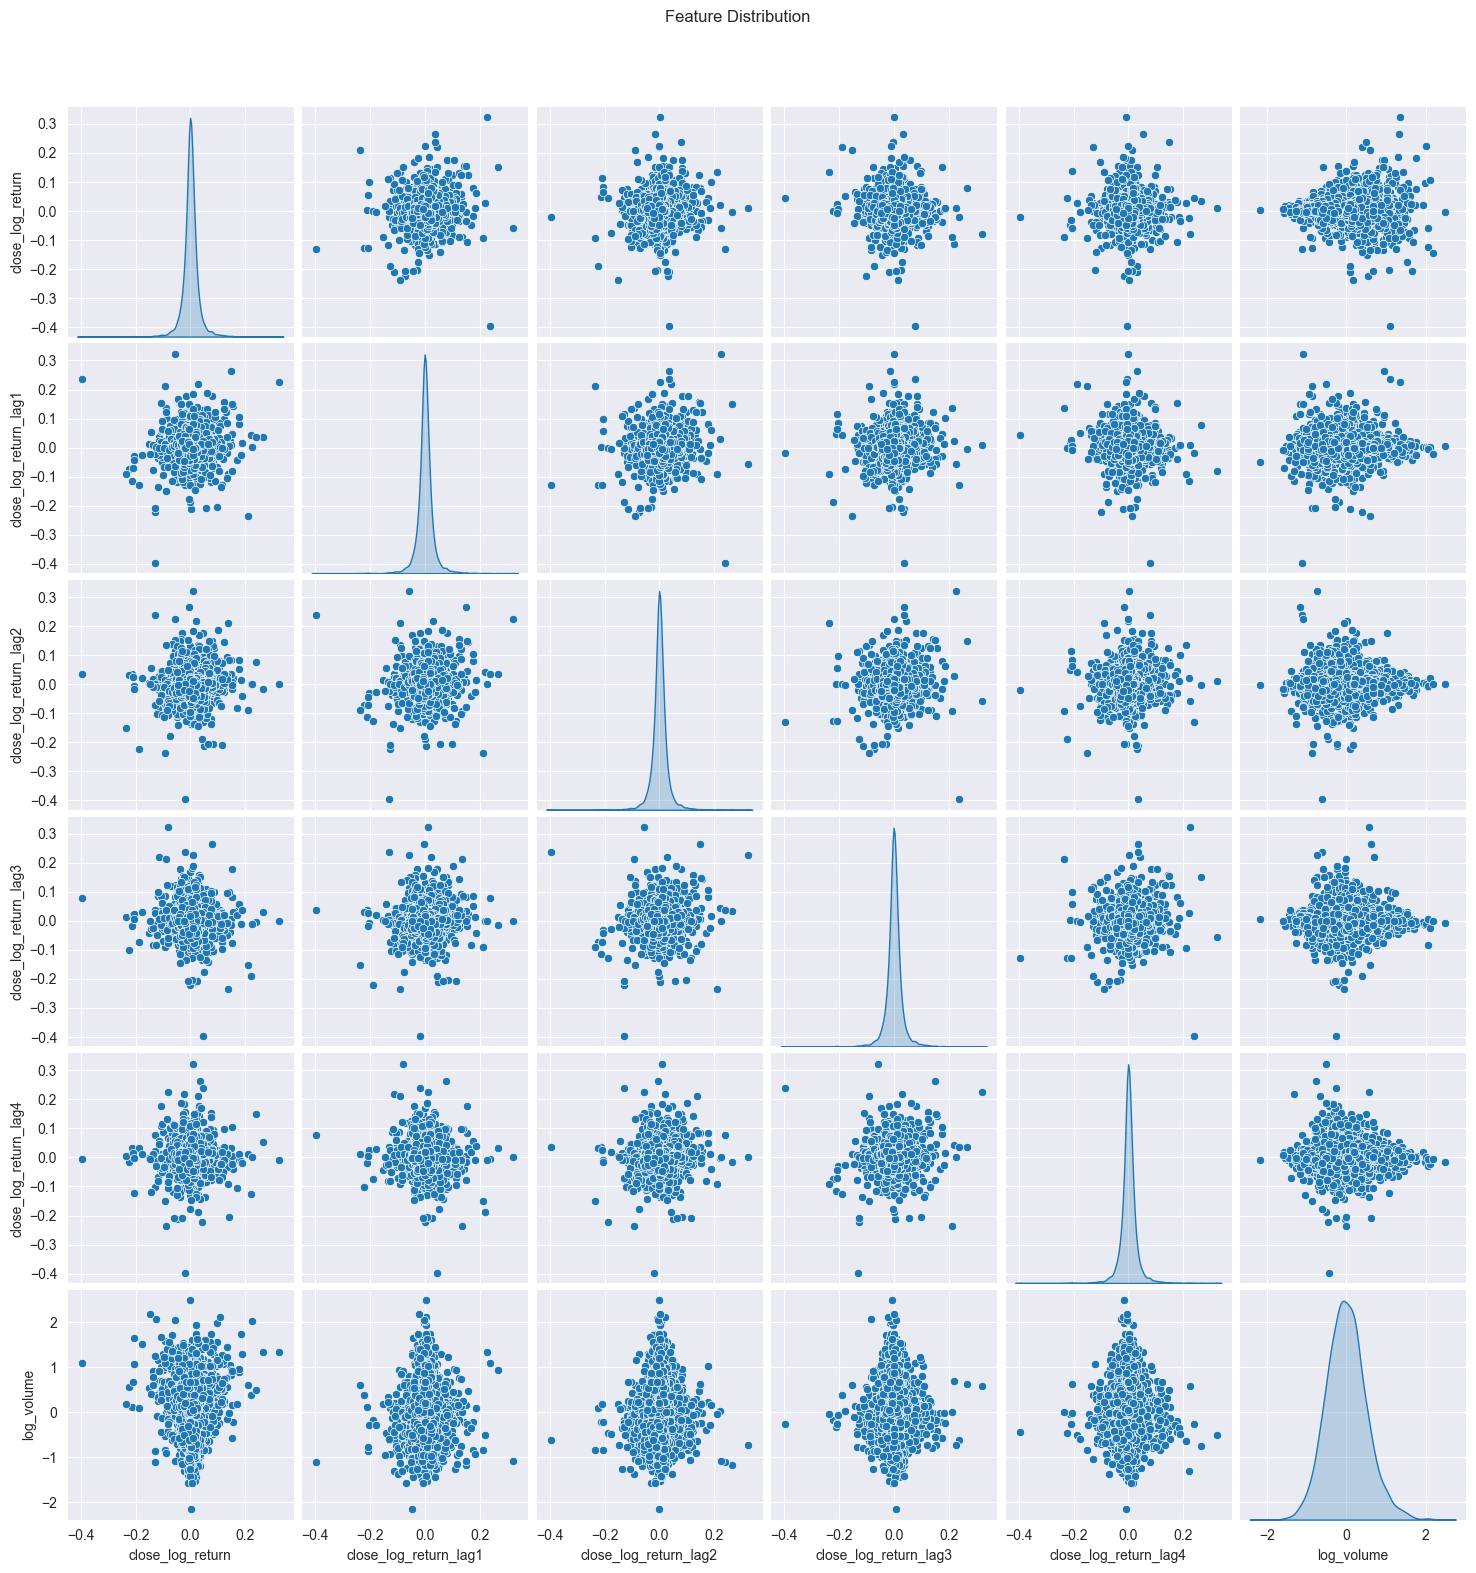

In [581]:
# plot feature distribution
visualization.plot_feature_distribution(df,["close_log_return","close_log_return_lag1","close_log_return_lag2","close_log_return_lag3","close_log_return_lag4","log_volume"])

### Feature Correlation vs Target
* Next we display the varying features and their absolute correlation to the close log return.

In [582]:
# plot feature correlation
visualization.display_feature_corr(df,"close_log_return")

Feature,Abs_correlation
str,f64
"""close_log_return""",1.0
"""close_log_return_lag3""",0.071062
"""close_log_return_lag2""",0.056896
"""close_log_return_lag1""",0.038158
"""log_volume_lag2""",0.030451
…,…
"""log_volume_lag4""",0.003111
"""log_volume_lag1""",0.002898
"""low""",0.002814


In [453]:
from model import set_seeds

### Model Development
* We utilized the Pytorch library to analyze two models:
* 1: Linear Regression - Best used for easier interoperability.
* 2: Neural Network - Given the non-linear relationship we observed above, initial expectation was for higher performance with the NN model.

* Results between the two models indicated that the NN model was too effected by the noise and thus settled for the Linear Regression to continue the analysis.

In [616]:
# Model Development
from src import model
# Set seed for reproducibility
set_seeds(seed=99)

# Features
from model import to_tensor
features = ["close_log_return_lag3","close_log_return_lag2","log_volume_lag2","log_volume_lag3"]
target = "close_log_return"

# Create Tensors and split dataframe after setting seeds
X_train, X_test, y_train, y_test = train_test_split(df,features,target,train_size=0.75)

In [584]:
from model import train_model

### Various iterations of the learning rate (lr) and epoch size were analyzed.
* The lr of 0.002 and epoch of 2500 created an adequate mix horizon before the model got too noisy on the loss rate.

In [617]:
# Trained Model with a focus on the linear model in Pytorch due to easier interoperability.
input_size = X_train.shape[1]
lr = 0.002
# Should the user wish to experiment, the argument of "linear" can be changed to "nn" for a neural network.

trained_model = train_model(X_train,y_train,input_size,"linear",lr=lr,epochs=2500,print_freq=500)


Model: Linear Regression
Starting training for 2500 epochs...
Epoch: 0000 | Loss: 0.263212
Epoch: 0500 | Loss: 0.018864
Epoch: 1000 | Loss: 0.018864
Epoch: 1500 | Loss: 0.018864
Epoch: 2000 | Loss: 0.018864

Training Complete.


### Evaluating Model Performance

In [643]:
# Evaluate model performance
from model import get_trade_results
y_hat = evaluate_model(trained_model, X_test)
results_df = get_trade_results(y_hat, y_test)
results_df

y_hat,y,is_won,signal,trade_log_return,equity_curve,B_H_log_return,B_H_equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32,f32,f32
0.000802,0.005105,true,1.0,0.005105,0.005105,0.005105,0.005105,0.0
-0.00054,-0.00123,true,-1.0,0.00123,0.006335,-0.00123,0.003875,0.0
0.002206,0.000879,true,1.0,0.000879,0.007214,0.000879,0.004754,0.0
0.000175,0.008918,true,1.0,0.008918,0.016132,0.008918,0.013672,0.0
-0.00139,-0.004187,true,-1.0,0.004187,0.020319,-0.004187,0.009485,0.0
…,…,…,…,…,…,…,…,…
0.001316,-0.046639,false,1.0,-0.046639,2.681078,-0.046639,1.289251,-0.123266
-0.000057,-0.024361,true,-1.0,0.024361,2.705439,-0.024361,1.26489,-0.098905
0.002846,0.011097,true,1.0,0.011097,2.716536,0.011097,1.275988,-0.087807


In [324]:
import numpy as np

mean_ret = results_df["trade_log_return"].mean()
total_ret = results_df["trade_log_return"].sum()
std = results_df["trade_log_return"].std()
ann_fac = np.sqrt(365 * 6)

sharpe = (mean_ret / std) * ann_fac
total_ret

1.395270586013794

In [461]:
from src.model import get_strategy_metrics

### Performance Metrics
* Significant improvement was found in the sharpe ratio when including the lagged volume feature.
* Strongest performance was found in feature close_log_return_lag3.

In [619]:
# Calculate performance metrics
trading_periods = 365*3 # formula is looking at 365 trading days * by 3 8 hour bars in a day.
ann_fac_sqrt = np.sqrt(trading_periods)
strategy_metrics_df = get_strategy_metrics(
    trade_results_df=results_df,
    annual_factor_sqrt=ann_fac_sqrt
)

print("--- PERFORMANCE SUMMARY ---")
print(strategy_metrics_df)


--- PERFORMANCE SUMMARY ---
shape: (1, 8)
┌────────────┬────────────┬────────────┬────────────┬──────────┬───────────┬───────────┬───────────┐
│ Total_Retu ┆ Annualized ┆ Max_Drawdo ┆ Drawdown_P ┆ Win_Rate ┆ Total_Tra ┆ Compound  ┆ Calmar_Ra │
│ rn         ┆ _Sharpe    ┆ wn         ┆ ct         ┆ ---      ┆ des       ┆ Return    ┆ tio       │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆ f64      ┆ ---       ┆ ---       ┆ ---       │
│ f64        ┆ f64        ┆ f64        ┆ f64        ┆          ┆ i64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪════════════╪══════════╪═══════════╪═══════════╪═══════════╡
│ 2.718306   ┆ 2.454972   ┆ 0.508483   ┆ -0.398593  ┆ 0.552347 ┆ 1385      ┆ 15.154626 ┆ 5.345912  │
└────────────┴────────────┴────────────┴────────────┴──────────┴───────────┴───────────┴───────────┘


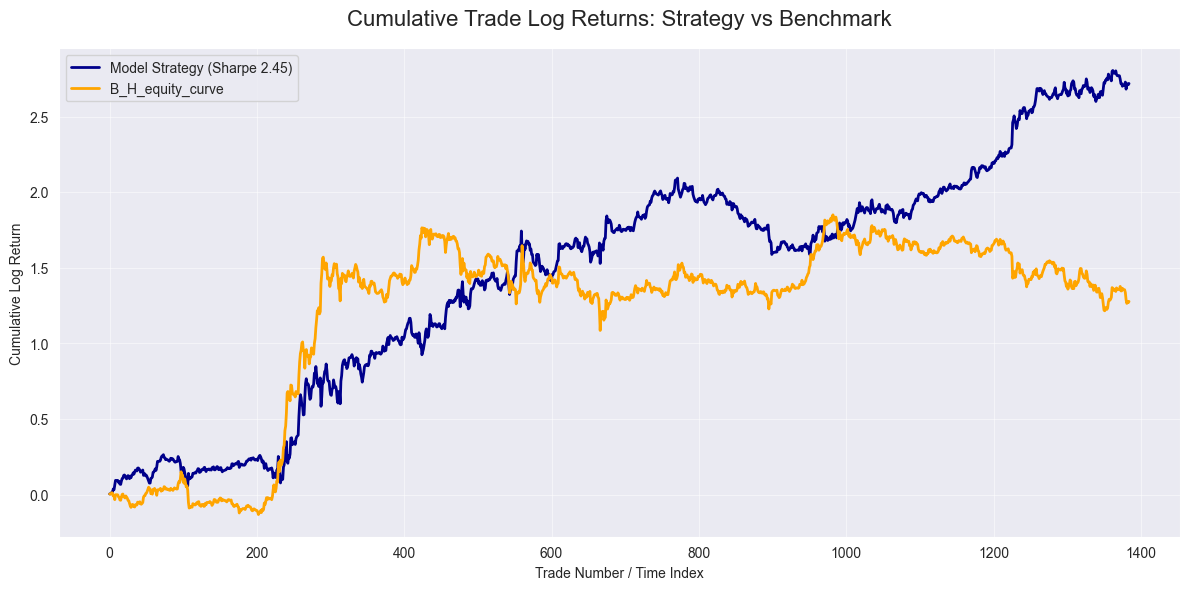

Strategy Alpha Correlation (R): 0.1191


In [655]:
# visualize equity curve in log space
from visualization import plot_cum_trade_log_returns

plot_cum_trade_log_returns(results_df,"equity_curve",benchmark_col="B_H_equity_curve")

correlation_val = results_df.select(

    pl.corr(
        pl.col("trade_log_return").cast(pl.Float64),
        pl.col("y").cast(pl.Float64)
    ).alias("Strategy_Market_R")
).item()

print(f"Strategy vs Benchmark Correlation (R): {correlation_val:.4f}")